In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)
from src.save_and_load_tools.save_load_utils import *
from src.grid.grid_env import GridEnv
from src.measures import *
from src.plotting_tools.plot_performance import plot_performance

import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def is_two_sided_from_grid_name(grid_name):
    return 'LG' in grid_name
    
    
def n_nodes_from_grid_name(grid_name):
    cable_lengths_string = re.findall('\[[^\]]+\]', grid_name)[0][1: -1]
    cable_lengths_list = re.findall('[0-9]+', cable_lengths_string)
    return np.sum([int(el) for el in cable_lengths_list])


def p_gen_min_from_grid_name(grid_name):
    return -float(re.findall('gen-min=-[0-9]+', grid_name)[0][8:])

def p_dg_min_from_grid_name(grid_name):
    return -float(re.findall('-dg-min=-[0-9]+', grid_name)[0][8:])

def line_i_max_from_grid_name(grid_name):
    return float(re.findall('line-max=[0-9]+', grid_name)[0][9:])


def prob_leaf_from_grid_name(grid_name):
    ind = grid_name.find('prob-leaf=')
    return float(grid_name[ind + 10:])

def avg_cable_length_from_random_grid_name(grid_name):
    cable_lengths_string = re.findall('\[[^\]]+\]', grid_name)[0][2: -1]
    cable_lengths_list = re.findall('[0-9]+', cable_lengths_string)
    return np.mean([int(el) for el in cable_lengths_list])


def load_and_compute_metrics(experiment_name, path_to_experiments, base_names_list=None, ptu_int=60):
    
    results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    if base_names_list is None:
        base_names_list = os.listdir(path_to_experiments + '/%s/' % experiment_name)
    for grid_name in base_names_list:
        #print('Spec', base_name)
        path_to_results_dict = path_to_experiments + '/%s/%s/results/' % (experiment_name, grid_name)
        scenarios, scenario_generator = load_scenarios(experiment_name, grid_name, path_to_experiments, ptu_int)
        grid = load_grid(experiment_name, grid_name, path_to_experiments)
        print(grid.n_loads, grid.n_gens, [g.p_min for g in grid.gens])
        #grid_id = 'p-gen-min=%d_i-line-max=%d' % (gen_p_min, line_i_max)
        #grid_name = grid.name[: first_ + 1] + grid_id + grid.name[first_:]
        grid.name = grid_name
        print(grid_name)
        results_dict_names = [f for f in os.listdir(path_to_results_dict) if '_results.pickle' in f]
        
        for rd_name in results_dict_names:
            pl_name = rd_name[:rd_name.find('results') - 1]
            pl_results_dict = load_results_dict(pl_name, experiment_name, grid_name, path_to_experiments)
            
            for sc_ind, sc_result in pl_results_dict.items():
                scenario = scenarios[sc_ind]
                w = measure_wealth(sc_result, scenario, grid)
                soc = measure_soc_percentage(sc_result, scenario)
                evs_charged = measure_charged_evs(sc_result, scenario, grid, .99)
                #n_lines_at_limit = measure_lines_at_limit(sc_result, scenario, grid, average=True, gap=0.01)
                #p_missmatch = measure_loads_misstmatch(sc_result, scenario, grid, average=True, gap=0.99)
                pl_time = sc_result['planning time'].mean()
                for key, val in sc_result.items():
                    results[grid.name][pl_name][key][sc_ind] = val
                #results[grid.name][pl_name]['Plans missmatch'][sc_ind] = p_missmatch
                #results[grid.name][pl_name]['Lines at limit'][sc_ind] = n_lines_at_limit / grid.n_lines
                results[grid.name][pl_name]['Wealth'][sc_ind] = w
                results[grid.name][pl_name]['Social welfare'][sc_ind] = w
                results[grid.name][pl_name]['SOC'][sc_ind] = soc
                results[grid.name][pl_name]['EVs charged'][sc_ind] = evs_charged
                results[grid.name][pl_name]['Pl. time'][sc_ind] = pl_time
                
    return results


planner_names_dict = \
{\
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_None': 'SOCP_full',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=present_None': 'SOCP_present',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=past_None': 'SOCP_past',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=blind_None': 'SOCP_blind',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node': 'SOCP_single-node',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node-unified': 'SOCP_single-node_uni',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node-weird': 'SOCP_single-node_weird',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel': 'SOCP_parallel',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel-unified': 'SOCP_parallel_uni',
 'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel-weird': 'SOCP_parallel_weird',
 'SOCPPlanner_normalize=True_future=no-future_ev-locations=full_None': 'SOCP_no-future',
 }

In [2]:
ptu_int = 30
experiment_folder = 'IEEE16'
experiment_name = 'IEEE16meshed_disc_loads-at-gens'
path_to_experiments = path_to_project + '/experiments/%s/' % experiment_folder

results_dict = {}

grid_names_list = os.listdir(path_to_experiments + '/%s/' % experiment_name)
#grid_names_list = ['CabledGrid[10, 10, 10]_gens-end=[False, False, False]_gens-inside=[True, True, True]_dgs=[[0, 8, 1, 8], [1, 9, 2, 9], [2, 7, 0, 7]]_i-line-max=35_p-gen-min=-42857']

results_dict.update(load_and_compute_metrics(experiment_name, path_to_experiments,
                                             grid_names_list, ptu_int))
    
planner_names_use = [\
                     'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_None',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=present_None',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=past_None',
                     'SOCPPlanner_normalize=True_future=known-future_ev-locations=blind_None',
                     'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node-unified',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_single-node-weird',
                     'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel-unified',
                     #'SOCPPlanner_normalize=True_future=known-future_ev-locations=full_parallel-weird',
                     #'SOCPPlanner_normalize=True_future=no-future_ev-locations=full_None',
                    ]

13 9 [-0.1, -0.1, -0.1, -14444, -14444, -14444, -14444, -14444, -14444]
IEEE16meshed_disc_loads-at-gens_g=15_i-line-max=17_p-gen-min=-14444
Loaded results dict
Loaded results dict
Loaded results dict
Loaded results dict
13 9 [-0.1, -0.1, -0.1, -14444, -14444, -14444, -14444, -14444, -14444]
IEEE16meshed_disc_loads-at-gens_g=15_i-line-max=32_p-gen-min=-14444
Loaded results dict
Loaded results dict
Loaded results dict
Loaded results dict
13 9 [-0.1, -0.1, -0.1, -14444, -14444, -14444, -14444, -14444, -14444]
IEEE16meshed_disc_loads-at-gens_g=15_i-line-max=10_p-gen-min=-14444
Loaded results dict
Loaded results dict
Loaded results dict
Loaded results dict
13 9 [-0.1, -0.1, -0.1, -14444, -14444, -14444, -14444, -14444, -14444]
IEEE16meshed_disc_loads-at-gens_g=15_i-line-max=40_p-gen-min=-14444
Loaded results dict
Loaded results dict
Loaded results dict
Loaded results dict
13 9 [-0.1, -0.1, -0.1, -14444, -14444, -14444, -14444, -14444, -14444]
IEEE16meshed_disc_loads-at-gens_g=15_i-line-max=

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


IEEE16_meshed_disc


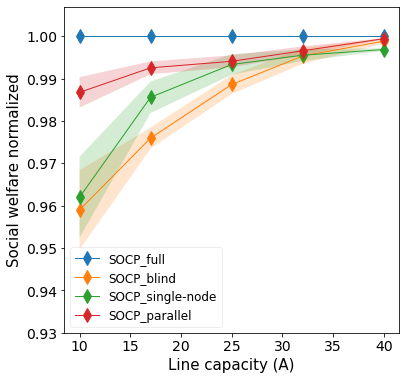

In [3]:
name = 'IEEE16_meshed_disc'
#name = 'scalability_diff-cables'
print(name)
save = True
y_label_per_metric = ['Social welfare normalized']
#y_label_per_metric  = None
y_min = .93
y_max = (1 + (1 - y_min)/10)
y_lim_per_metric = [(y_min, y_max)]
#y_lim_per_metric = None

filter_by = lambda x: True
#filter_by = lambda x: line_i_max_from_grid_name(x) <= 200
#filter_by = lambda x: p_gen_min_from_grid_name(x) in [72000]
#filter_by = lambda x: line_i_max_from_grid_name (x) in [56]


plot_by = line_i_max_from_grid_name # line_i_max_from_grid_name
#plot_by = p_gen_min_from_grid_name
#plot_by = n_nodes_from_grid_name


group_by = p_gen_min_from_grid_name #is_two_sided_from_grid_name
#group_by = line_i_max_from_grid_name
#group_by = p_dg_min_from_grid_name
#group_by = lambda x: True

plot_by_name = 'Line capacity (A)'
#plot_by_name = 'Number of loads'
#plot_by_name = 'Gen. capacity (W)'

group_by_name = 'Gen. capacity'
#group_by_name = 'Line capacity'

group_by_units = 'W' if group_by_name == 'Gen. capacity' else 'A'

#name = 'Performance ' + experiment_name
group_by_size = 0
figsize = (6, 6)

metrics_to_plot = ['Social welfare',]
metrics_normalize = [True, False, False]
pl_baseline = planner_names_use[0]

sc_inds_list = list(results_dict[grid_names_list[0]][planner_names_use[0]]['Wealth'].keys())

plt_config = {'alpha': 0.2, 'linewidth': 1, 'markersize': 10, 'marker': 'd', 'font_size': 1,
              'axes_t_size': 18, 'axes_l_size': 15, 'xtick_size': 14, 'ytick_size': 14, 
              'legend_size': 12, 'title_size': 0,  'group_by_size': group_by_size, 'bbox_to_anchor': None}

#plt_config['marker'] = dict()
#for pl_name, m in zip(planner_names_use, ['v', '^', '>', '<']):
#    plt_config['marker'][pl_name] = m

plot_performance(results_dict, planner_names_use, planner_names_dict, metrics_to_plot, metrics_normalize,
                 filter_by, plot_by, group_by, plot_by_name,  group_by_name, group_by_units,
                 sc_inds_list, figsize, plt_config, pl_baseline, 
                 path_to_project, name, y_label_per_metric, y_lim_per_metric, save=save, plot_title=False)